In [1]:
import pandas as pd
import numpy as np
from zipfile import ZipFile, Path
from datetime import datetime
import warnings
warnings.filterwarnings("ignore")

In [2]:
import seaborn as sns

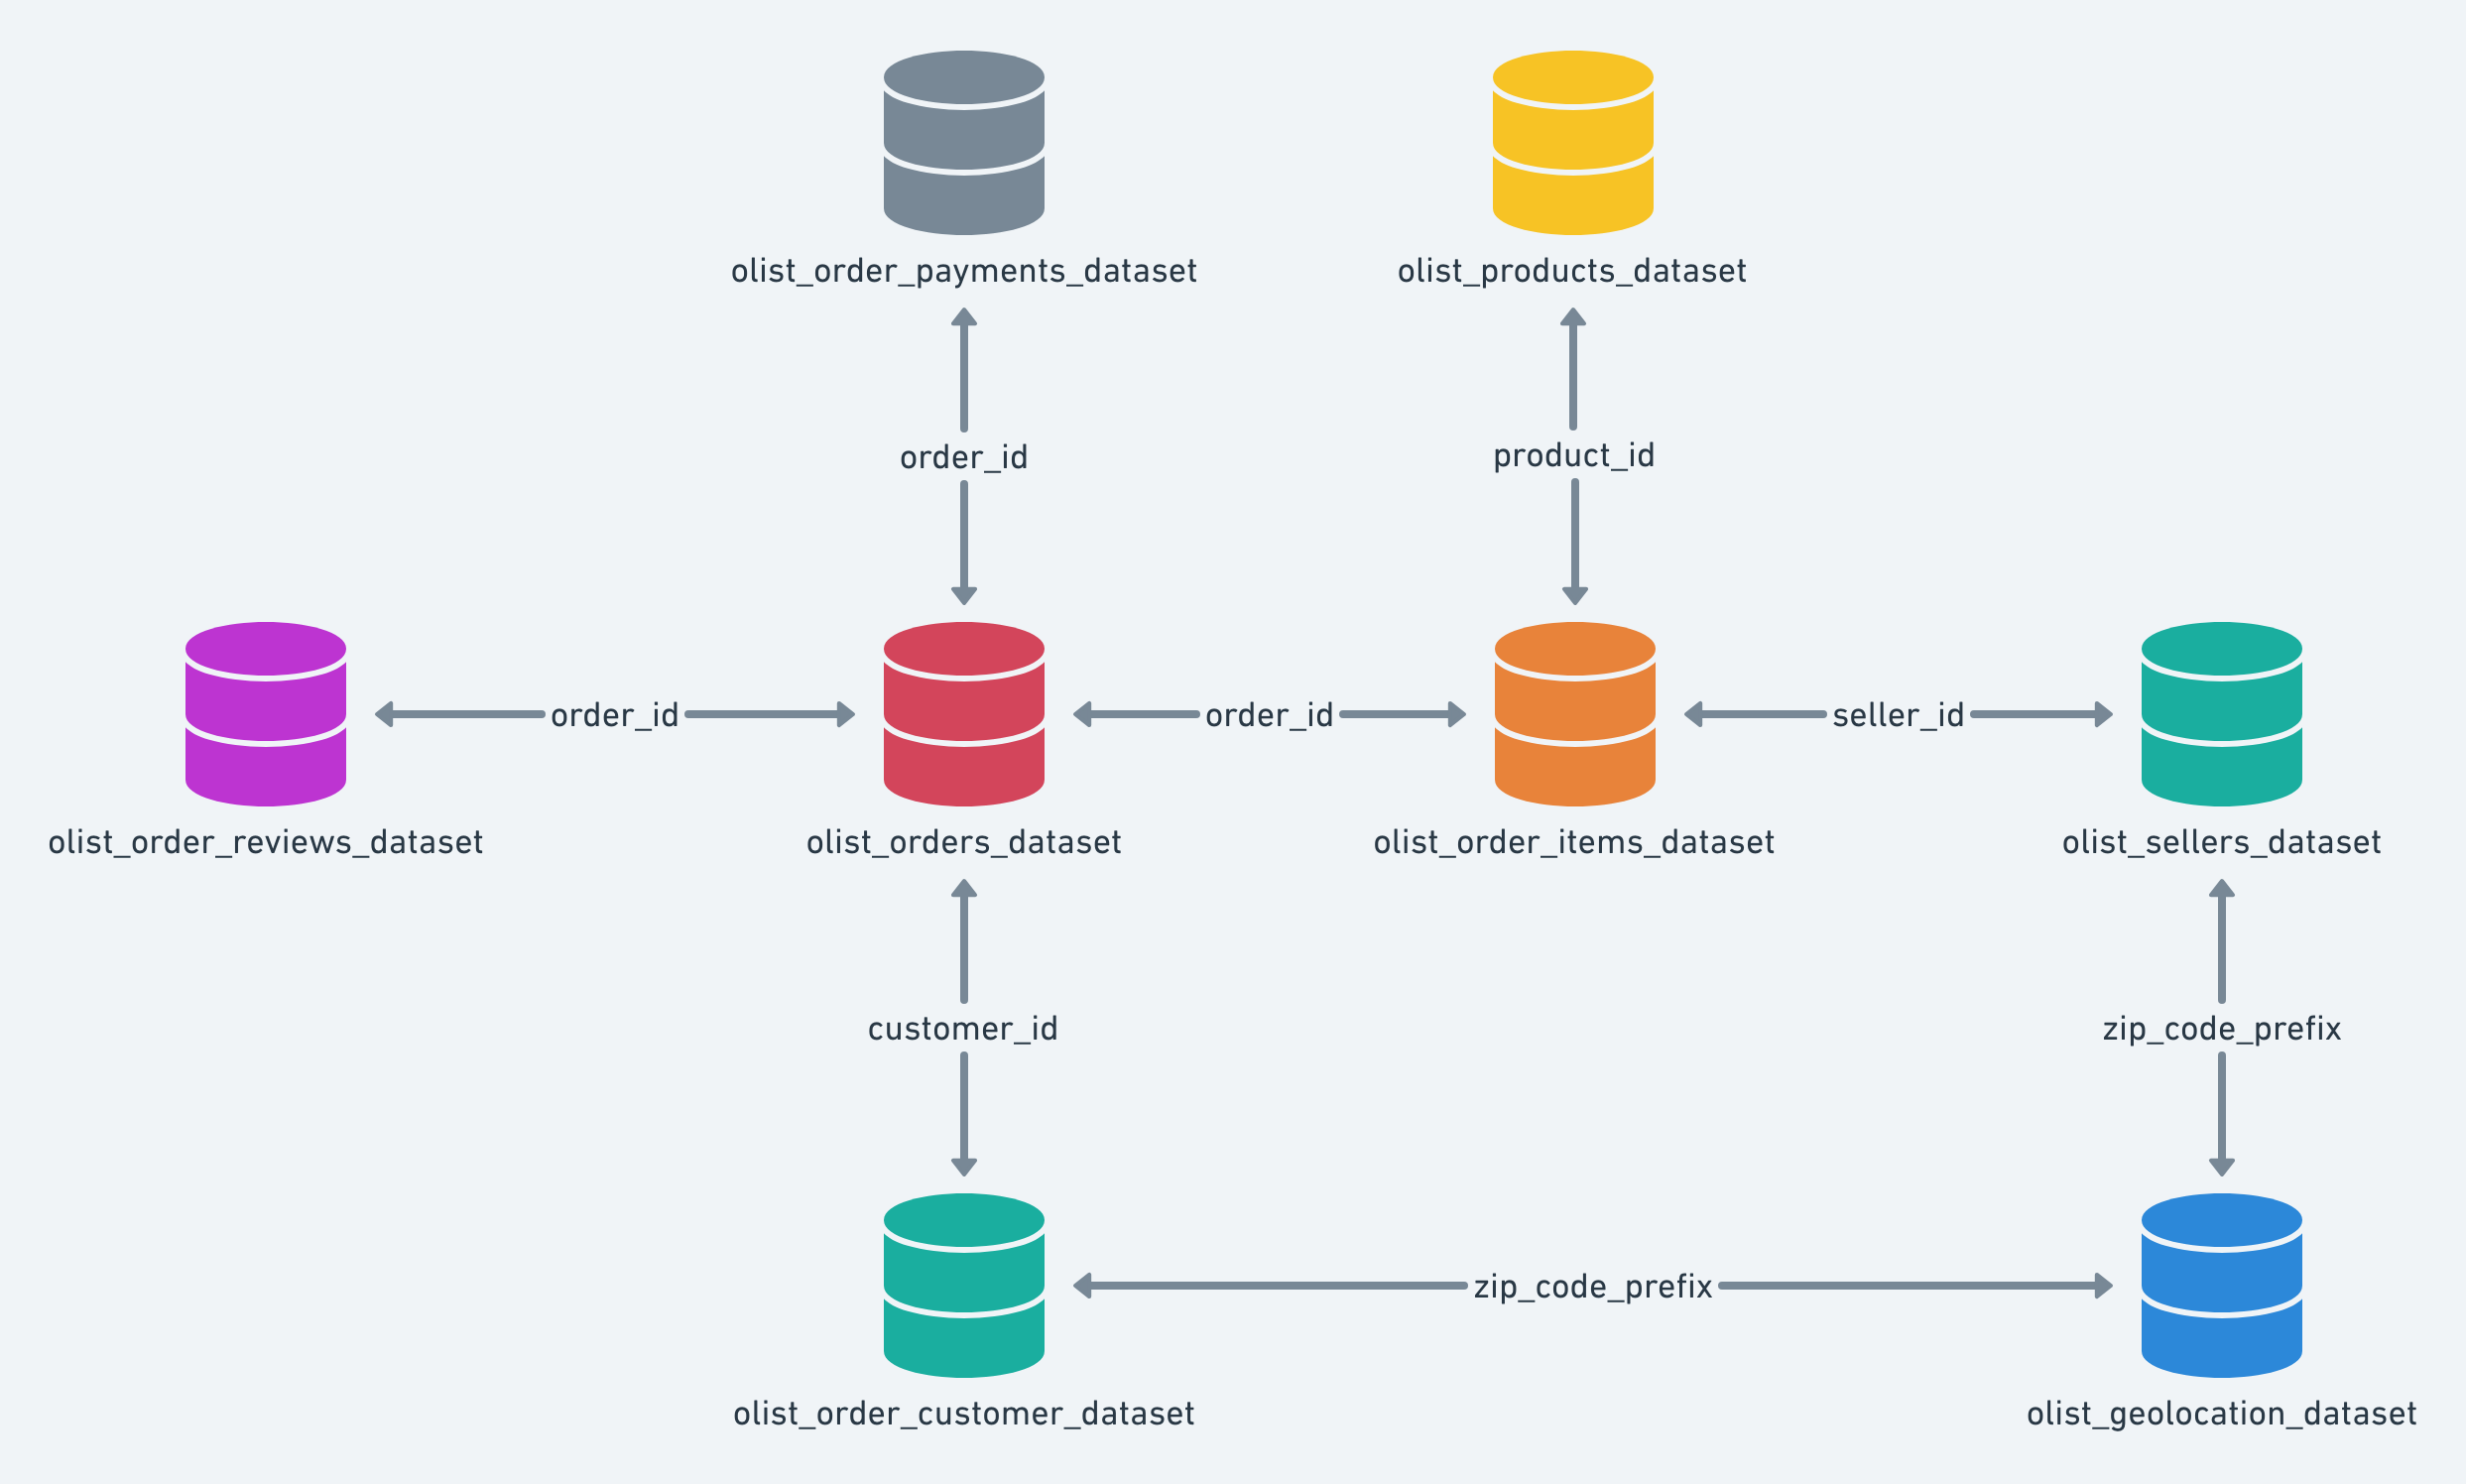

In [3]:
LIST_OF_FILES = ['olist_customers_dataset.csv',
'olist_geolocation_dataset.csv',
'olist_order_items_dataset.csv',
'olist_order_payments_dataset.csv',
'olist_order_reviews_dataset.csv',
'olist_orders_dataset.csv',
'olist_products_dataset.csv',
'olist_sellers_dataset.csv',
'product_category_name_translation.csv']

In [4]:
# Each dataset is stored into a position, accessible by its name as key
dict_dataset = {}

# Read all files
with ZipFile("archive.zip") as myzip:
    for file_name in LIST_OF_FILES:
        with myzip.open(file_name) as file:
            dict_dataset[file_name.split('.')[0]] = pd.read_csv(file, header=0, delimiter=",")

In [5]:
pd.Series(dict_dataset.keys())

0              olist_customers_dataset
1            olist_geolocation_dataset
2            olist_order_items_dataset
3         olist_order_payments_dataset
4          olist_order_reviews_dataset
5                 olist_orders_dataset
6               olist_products_dataset
7                olist_sellers_dataset
8    product_category_name_translation
dtype: object

# FULL TABLE

In [6]:
df = dict_dataset['olist_geolocation_dataset']

In [7]:
%%time
df['LAT_LONG'] = df.apply(lambda row :  str(row['geolocation_lat']) + str(row['geolocation_lng']), axis=1)

Wall time: 8.65 s


In [8]:
df_lat_long_in_CEPs = df.groupby('geolocation_zip_code_prefix').apply(lambda group : group['LAT_LONG'].nunique())

In [9]:
df_lat_long_in_CEPs =  df_lat_long_in_CEPs.rename('diff_lat_long').reset_index()

In [10]:
df_lat_long_in_CEPs.sort_values('diff_lat_long', ascending=False).head(10)

,geolocation_zip_code_prefix,diff_lat_long
9536,38400,746
4501,11680,727
8728,35500,726
4528,11740,666
9015,36400,627
9719,39400,620
8579,35162,611
9542,38408,600
9239,37200,595
8867,35900,589


In [11]:
df[df['geolocation_zip_code_prefix'] == 38400].head(5)

,geolocation_zip_code_prefix,geolocation_lat,geolocation_lng,geolocation_city,geolocation_state,LAT_LONG
645450,38400,-18.915960,-48.278974,uberlandia,MG,-18.91595976602804-48.278974174995646
645456,38400,-18.900442,-48.260759,uberlandia,MG,-18.900442445467096-48.26075855813959
645460,38400,-18.913015,-48.262132,uberlandia,MG,-18.913015152374623-48.26213189982101
645461,38400,-18.922381,-48.282111,uberlandia,MG,-18.92238123980033-48.28211103081535
645471,38400,-18.922160,-48.271125,uberlandia,MG,-18.922160210658436-48.27112484984707


In [12]:
LIST = []
for i in dict_dataset:
    LIST.append((i,dict_dataset[i].shape[0]))

In [13]:
pd.DataFrame(LIST, columns=['table', 'size']).sort_values('size', ascending=False)

,table,size
1,olist_geolocation_dataset,1000163
2,olist_order_items_dataset,112650
3,olist_order_payments_dataset,103886
0,olist_customers_dataset,99441
5,olist_orders_dataset,99441
4,olist_order_reviews_dataset,99224
6,olist_products_dataset,32951
7,olist_sellers_dataset,3095
8,product_category_name_translation,71


In [14]:
# olist_order_items_dataset

In [15]:
df_geolocation_dataset = dict_dataset['olist_geolocation_dataset']
df_orders_dataset = dict_dataset['olist_orders_dataset']
df_order_items_dataset = dict_dataset['olist_order_items_dataset']
df_order_payments_dataset = dict_dataset['olist_order_payments_dataset']
df_customers_dataset = dict_dataset['olist_customers_dataset']
df_order_reviews_dataset = dict_dataset['olist_order_reviews_dataset']
df_products_dataset = dict_dataset['olist_products_dataset']
df_sellers_dataset = dict_dataset['olist_sellers_dataset']
df_product_category_name_translation = dict_dataset['product_category_name_translation']

In [16]:
# <!-- ![backupPreview.png](attachment:backupPreview.png) -->

## A: order_items_dataset + products_dataset

In [17]:
A = df_order_items_dataset.merge(df_products_dataset, on='product_id', how='left')

In [18]:
A.head(2)

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value,product_category_name,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm
0,00010242fe8c5a6d1ba2dd792cb16214,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-09-19 09:45:35,58.9,13.29,cool_stuff,58.0,598.0,4.0,650.0,28.0,9.0,14.0
1,00018f77f2f0320c557190d7a144bdd3,1,e5f2d52b802189ee658865ca93d83a8f,dd7ddc04e1b6c2c614352b383efe2d36,2017-05-03 11:05:13,239.9,19.93,pet_shop,56.0,239.0,2.0,30000.0,50.0,30.0,40.0


## B: sellers_dataset + geolocation_dataset

In [19]:
B = df_sellers_dataset.merge(df_geolocation_dataset.drop_duplicates('geolocation_zip_code_prefix'), \
                             how='left', \
                             left_on=['seller_zip_code_prefix'], \
                             right_on=['geolocation_zip_code_prefix'])

In [20]:
# List the columns in which we want to add a sufix
columns_to_add_sufix = ['geolocation_zip_code_prefix', 'geolocation_lat', 'geolocation_lng', 'geolocation_city', 'geolocation_state', 'LAT_LONG']

# Create a function to do that to the given columns
func_modifier = lambda col : str(col + "_seller")

# Apply the function to the desired columns
new_columns_names = list(map(lambda x : func_modifier(x) if x in columns_to_add_sufix else x, B))

B.columns = new_columns_names

## C: A + B

In [21]:
C = A.merge(B, how='left', on='seller_id')

In [22]:
C.head(2)

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value,product_category_name,product_name_lenght,product_description_lenght,...,product_width_cm,seller_zip_code_prefix,seller_city,seller_state,geolocation_zip_code_prefix_seller,geolocation_lat_seller,geolocation_lng_seller,geolocation_city_seller,geolocation_state_seller,LAT_LONG_seller
0,00010242fe8c5a6d1ba2dd792cb16214,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-09-19 09:45:35,58.9,13.29,cool_stuff,58.0,598.0,...,14.0,27277,volta redonda,SP,27277.0,-22.498183,-44.123614,volta redonda,RJ,-22.498182754371285-44.12361371579433
1,00018f77f2f0320c557190d7a144bdd3,1,e5f2d52b802189ee658865ca93d83a8f,dd7ddc04e1b6c2c614352b383efe2d36,2017-05-03 11:05:13,239.9,19.93,pet_shop,56.0,239.0,...,40.0,3471,sao paulo,SP,3471.0,-23.566258,-46.518417,sao paulo,SP,-23.56625832001269-46.51841724632121


## D: customer_dataset + geolocation_dataset

In [23]:
D = df_customers_dataset.merge(df_geolocation_dataset.drop_duplicates('geolocation_zip_code_prefix'), how='left', left_on=['customer_zip_code_prefix'], right_on=['geolocation_zip_code_prefix'])

In [24]:
# List the columns in which we want to add a sufix
columns_to_add_sufix = ['geolocation_zip_code_prefix', 'geolocation_lat', 'geolocation_lng', 'geolocation_city', 'geolocation_state']

# Create a function to do that to the given columns
func_modifier = lambda col : str(col + "_customer")

# Apply the function to the desired columns
new_columns_names = list(map(lambda x : func_modifier(x) if x in columns_to_add_sufix else x, D))

D.columns = new_columns_names

## E: All left tables

In [25]:
E = df_orders_dataset.merge(df_order_payments_dataset, how='left', on='order_id') \
                 .merge(df_order_reviews_dataset, how='left', on='order_id') \
                 .merge(D, how='left', on='customer_id')

## FULL TABLE

In [26]:
df_full_table = E.merge(C, how='left', on='order_id')

### Coverting to timestamp

In [27]:
orders_date_columns = ['order_purchase_timestamp', 'order_approved_at', 'order_delivered_carrier_date', 'order_delivered_customer_date', 'order_estimated_delivery_date']

for date_col in orders_date_columns:
    df_full_table[date_col] = pd.to_datetime(df_full_table[date_col])

In [28]:
# Python 3 program to calculate Distance Between Two Points on Earth
from math import radians, cos, sin, asin, sqrt
def distance(lat1, lat2, lon1, lon2):
     
    # The math module contains a function named
    # radians which converts from degrees to radians.
    lon1 = radians(lon1)
    lon2 = radians(lon2)
    lat1 = radians(lat1)
    lat2 = radians(lat2)
      
    # Haversine formula
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    a = sin(dlat / 2)**2 + cos(lat1) * cos(lat2) * sin(dlon / 2)**2
 
    c = 2 * asin(sqrt(a))
    
    # Radius of earth in kilometers. Use 3956 for miles
    r = 6371
      
    # calculate the result
    return(c * r)
     
     
# driver code
lat1 = 53.32055555555556
lat2 = 53.31861111111111
lon1 = -1.7297222222222221
lon2 =  -1.6997222222222223
print(distance(lat1, lat2, lon1, lon2), "K.M")

2.0043678382716137 K.M


In [29]:
coords_cols = [col for col in df_full_table.columns if (('geolocation_lat' in col) or ('geolocation_lng' in col))]
df_full_table[['seller_city', 'customer_city', 'seller_id', 'customer_id'] + coords_cols]

,seller_city,customer_city,seller_id,customer_id,geolocation_lat_customer,geolocation_lng_customer,geolocation_lat_seller,geolocation_lng_seller
0,maua,sao paulo,3504c0cb71d7fa48d967e0e4c94d59d9,9ef432eb6251297304e76186b10a928d,-23.574809,-46.587471,-23.680114,-46.452454
1,maua,sao paulo,3504c0cb71d7fa48d967e0e4c94d59d9,9ef432eb6251297304e76186b10a928d,-23.574809,-46.587471,-23.680114,-46.452454
2,maua,sao paulo,3504c0cb71d7fa48d967e0e4c94d59d9,9ef432eb6251297304e76186b10a928d,-23.574809,-46.587471,-23.680114,-46.452454
3,belo horizonte,barreiras,289cdb325fb7e7f891c38608bf9e0962,b0830fb4747a6c6d20dea0b8c802d7ef,-12.169860,-44.988369,-19.810119,-43.984727
4,guariba,vianopolis,4869f7a5dfa277a7dca6462dcf3b52b2,41ce2a54c0b03bf3443c3d931a367089,-16.746337,-48.514624,-21.362358,-48.232976
...,...,...,...,...,...,...,...,...
119138,tupa,praia grande,1f9ab4708f3056ede07124aad39a2554,1fca14ff2861355f6e5f14306ff977a7,-24.001467,-46.446355,-21.935321,-50.497562
119139,sao paulo,nova vicosa,d50d79cb34e38265a8649c383dcffd48,1aa71eb042121263aafbe80c1b562c9c,-17.891522,-39.370942,-23.551013,-46.448489
119140,ilicinea,japuiba,a1043bafd471dff536d0c462352beb48,b331b74b18dc79bcdf6532d51e1637c1,-22.555985,-42.690761,-20.944706,-45.827098
119141,ilicinea,japuiba,a1043bafd471dff536d0c462352beb48,b331b74b18dc79bcdf6532d51e1637c1,-22.555985,-42.690761,-20.944706,-45.827098


In [318]:
# df_full_table.to_csv('df_full.csv', sep=';', decimal='.')

In [30]:
def calculate_distance_between_seller_and_customer(seller_id, customer_id):
    seller_lat = df_full_table[df_full_table['seller_id'] == seller_id]['geolocation_lat_seller'].head(1).values[0]
    seller_lng = df_full_table[df_full_table['seller_id'] == seller_id]['geolocation_lng_seller'].head(1).values[0]

    customer_lat = df_full_table[df_full_table['customer_id'] == customer_id]['geolocation_lat_customer'].head(1).values[0]
    customer_lng = df_full_table[df_full_table['customer_id'] == customer_id]['geolocation_lng_customer'].head(1).values[0]
    
    return distance(lat1=seller_lat, lat2=customer_lat, lon1=seller_lng , lon2=customer_lng)

In [31]:
orders_date_columns = ['order_purchase_timestamp', 'order_approved_at', 'order_delivered_carrier_date', 'order_delivered_customer_date', 'order_estimated_delivery_date']

In [32]:
df_customer_seller_distance_analysis = df_full_table.drop_duplicates('order_id')[['customer_id', 'seller_id'] + coords_cols + orders_date_columns]

In [33]:
df_customer_seller_distance_analysis = df_customer_seller_distance_analysis.dropna(subset=['customer_id', 'seller_id'])

In [34]:
%%time
df_customer_seller_distance_analysis['distance'] = \
                            df_customer_seller_distance_analysis.apply(lambda row : distance(lat1=row['geolocation_lat_seller'],
                                     lat2=row['geolocation_lat_customer'],
                                     lon1=row['geolocation_lng_seller'] ,
                                     lon2=row['geolocation_lng_customer']), axis=1)

Wall time: 2.5 s


# CORRELATION Hours to deliever X  Distance

In [35]:
df_customer_seller_distance_analysis['days_to_deliver'] = (df_customer_seller_distance_analysis['order_delivered_customer_date'] - df_customer_seller_distance_analysis['order_purchase_timestamp']).dt.days
df_customer_seller_distance_analysis['delta_to_deliver'] = df_customer_seller_distance_analysis['order_delivered_customer_date'] - df_customer_seller_distance_analysis['order_purchase_timestamp']

In [36]:
def days_hours_minutes(td):
    return td.days * 24 + td.seconds//3600

In [37]:
df_customer_seller_distance_analysis['hours_to_deliver'] = df_customer_seller_distance_analysis['delta_to_deliver'].apply(days_hours_minutes)

In [38]:
df_customer_seller_distance_analysis['log_distance'] = np.log(df_customer_seller_distance_analysis['distance'])

# 95% dos dados levam menos de 29 dias

In [39]:
df_customer_seller_distance_analysis = df_customer_seller_distance_analysis.dropna(subset=['hours_to_deliver'])
np.quantile(df_customer_seller_distance_analysis['hours_to_deliver'], q=[0.25, 0.5, 0.75, 0.95])

array([162., 245., 377., 702.])

In [40]:
df_customer_seller_distance_analysis = df_customer_seller_distance_analysis.dropna(subset=['distance'])
np.quantile(df_customer_seller_distance_analysis['distance'], q=[0.25, 0.5, 0.75, 0.95])

array([ 185.06219128,  433.81527456,  798.53242451, 2096.44625204])

In [41]:
df_customer_seller_distance_analysis_optimized = df_customer_seller_distance_analysis \
                        [(df_customer_seller_distance_analysis['hours_to_deliver'] <= 720) & (df_customer_seller_distance_analysis['distance'] <= 2300)] 

In [42]:
df_customer_seller_distance_analysis_optimized['distance_1000_km'] = df_customer_seller_distance_analysis_optimized['distance'] / 1000

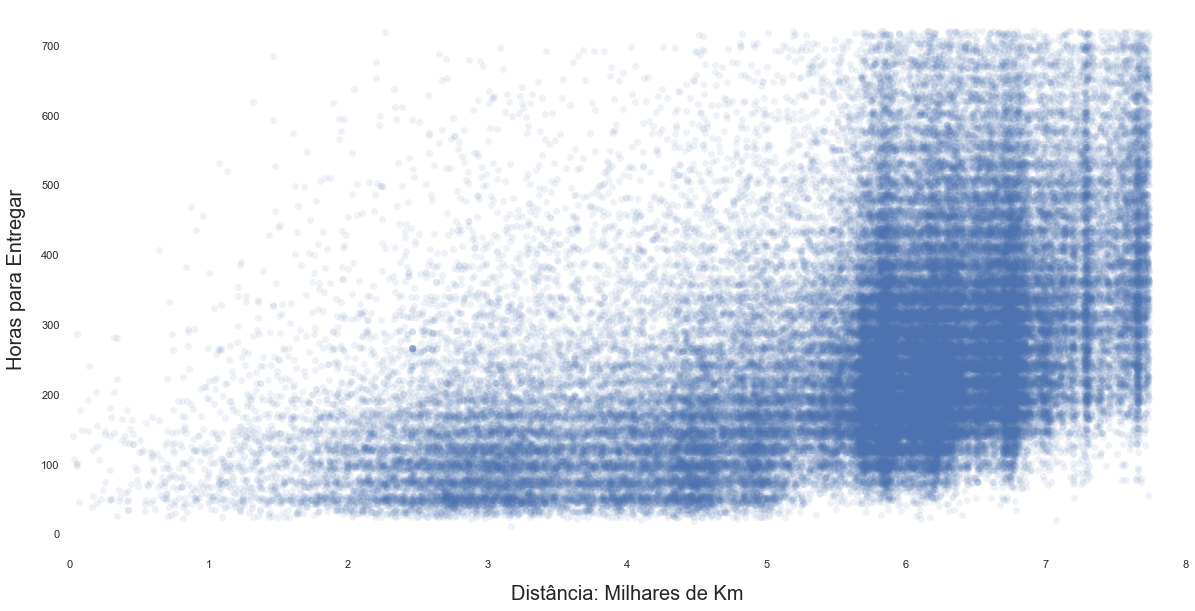

In [43]:
import matplotlib.pyplot as plt
sns.set(rc={'axes.facecolor':'white'}) #para dark mode no vscode
fig, ax1 = plt.subplots(nrows=1,figsize=(20,10))

sns.scatterplot(data=df_customer_seller_distance_analysis_optimized, x="log_distance", y='hours_to_deliver', ax = ax1, alpha=0.09, s=50, linewidth=0)
# sns.regplot(data=df_customer_seller_distance_analysis_optimized, x='log_distance',y='hours_to_deliver',order=10, ax=ax1)
# sns.regplot(data=df_customer_seller_distance_analysis_optimized, x='log_distance', y='hours_to_deliver', logistic=True, n_boot=500, y_jitter=.03)


# Changing ticks formatting
ax1.set_xlim(0,8)
ax1.set_xlabel(xlabel='Distância: Milhares de Km', labelpad=15)
ax1.xaxis.label.set_fontsize(20)
ax1.set_ylabel(ylabel='Horas para Entregar', labelpad=15)
ax1.yaxis.label.set_fontsize(20)

In [44]:
# sns.scatterplot(x=df_customer_seller_distance_analysis['distance'], y=df_customer_seller_distance_analysis['days_to_deliver'], ax=ax1)

# CORRELATION Delay in Hours X  Distance

In [45]:
df_customer_seller_distance_analysis['hours_delay'] = (df_customer_seller_distance_analysis['order_estimated_delivery_date'] - df_customer_seller_distance_analysis['order_delivered_customer_date']).dt.days
df_customer_seller_distance_analysis['delta_delay'] = df_customer_seller_distance_analysis['order_estimated_delivery_date'] - df_customer_seller_distance_analysis['order_delivered_customer_date']

# 95% tem menos de 25 horas de atraso

In [46]:
df_customer_seller_distance_analysis = df_customer_seller_distance_analysis.dropna(subset=['hours_delay'])
np.quantile(df_customer_seller_distance_analysis['hours_delay'], q=[0.25, 0.5, 0.75, 0.95])

array([ 6., 11., 16., 25.])

In [47]:
df_customer_seller_distance_analysis_optimized = df_customer_seller_distance_analysis \
                        [df_customer_seller_distance_analysis['hours_delay'] <= 26]

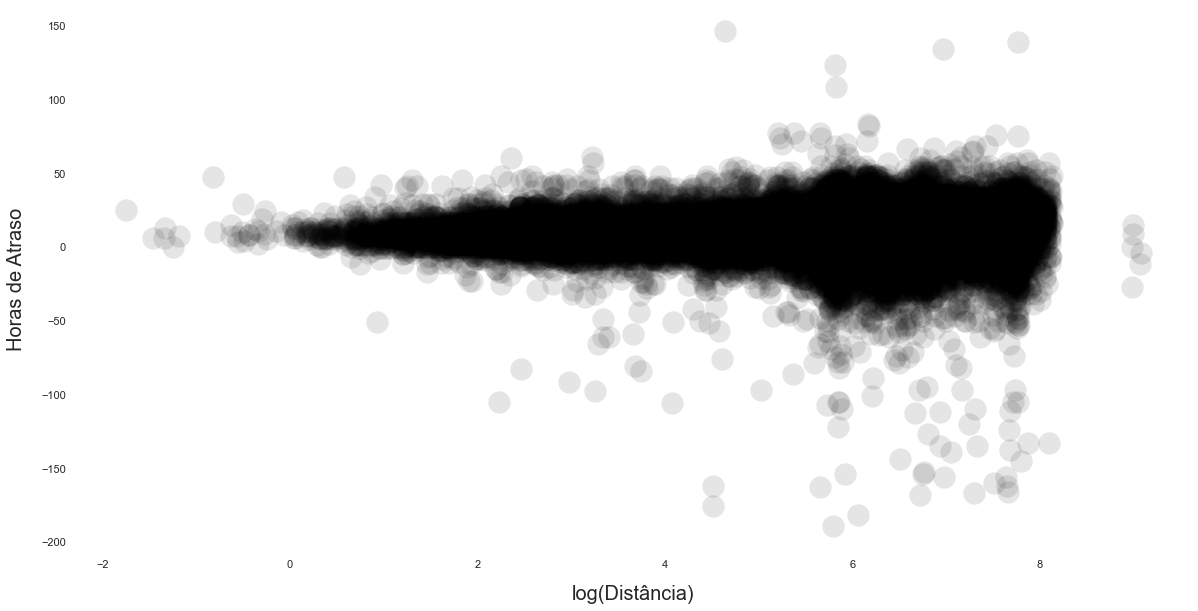

In [48]:
import matplotlib.pyplot as plt
sns.set(rc={'axes.facecolor':'white'}) #para dark mode no vscode
fig, ax1 = plt.subplots(nrows=1,figsize=(20,10))

sns.scatterplot(data=df_customer_seller_distance_analysis, x="log_distance", y='hours_delay', ax = ax1, alpha=0.1, s=500, color='black', linewidth=0)

# Changing ticks formatting
ax1.set_xlabel(xlabel='log(Distância)', labelpad=15)
ax1.xaxis.label.set_fontsize(20)
ax1.set_ylabel(ylabel='Horas de Atraso', labelpad=15)
ax1.yaxis.label.set_fontsize(20)

In [49]:
# pd.read_csv('df_full_table', sep=';', decimal='.')

In [251]:
df_full_table.columns

Index(['order_id', 'customer_id', 'order_status', 'order_purchase_timestamp',
       'order_approved_at', 'order_delivered_carrier_date',
       'order_delivered_customer_date', 'order_estimated_delivery_date',
       'payment_sequential', 'payment_type', 'payment_installments',
       'payment_value', 'review_id', 'review_score', 'review_comment_title',
       'review_comment_message', 'review_creation_date',
       'review_answer_timestamp', 'customer_unique_id',
       'customer_zip_code_prefix', 'customer_city', 'customer_state',
       'geolocation_zip_code_prefix_customer', 'geolocation_lat_customer',
       'geolocation_lng_customer', 'geolocation_city_customer',
       'geolocation_state_customer', 'LAT_LONG', 'order_item_id', 'product_id',
       'seller_id', 'shipping_limit_date', 'price', 'freight_value',
       'product_category_name', 'product_name_lenght',
       'product_description_lenght', 'product_photos_qty', 'product_weight_g',
       'product_length_cm', 'product_h

In [50]:
df_full_table_no_duplicates = df_full_table.drop_duplicates('order_id')

In [51]:
ESTADOS_SUDESTE = ['ES', 'RJ', 'MG', 'SP']

In [52]:
df_full_table_no_duplicates['IS_SUDESTE'] = df_full_table_no_duplicates['customer_state'].apply(lambda x : 1 if x in (ESTADOS_SUDESTE) else 0)

In [53]:
df_sudeste = df_full_table_no_duplicates[df_full_table_no_duplicates['IS_SUDESTE'] == 1]
df_resto_brasil = df_full_table_no_duplicates[df_full_table_no_duplicates['IS_SUDESTE'] == 0] 

In [54]:
# df_sudeste['amout_transactions'] = .size().rename('qtd_in_city').reset_index()

In [55]:
df_sudeste

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,payment_sequential,payment_type,...,seller_zip_code_prefix,seller_city,seller_state,geolocation_zip_code_prefix_seller,geolocation_lat_seller,geolocation_lng_seller,geolocation_city_seller,geolocation_state_seller,LAT_LONG_seller,IS_SUDESTE
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18,1.0,credit_card,...,9350.0,maua,SP,9350.0,-23.680114,-46.452454,maua,SP,-23.68011442853022-46.4524537436668,1
6,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26,1.0,credit_card,...,8752.0,mogi das cruzes,SP,8752.0,-23.551707,-46.260979,mogi das cruzes,SP,-23.551706513599484-46.260979398542325,1
9,6514b8ad8028c9f2cc2374ded245783f,9bdf08b4b3b52b5526ff42d37d47f222,delivered,2017-05-16 13:10:30,2017-05-16 13:22:11,2017-05-22 10:07:46,2017-05-26 12:55:51,2017-06-07,1.0,credit_card,...,12940.0,atibaia,SP,12940.0,-23.112774,-46.548885,atibaia,SP,-23.112774381969185-46.5488845105504,1
11,e69bfb5eb88e0ed6a785585b27e16dbf,31ad1d1b63eb9962463f764d4e6e0c9d,delivered,2017-07-29 11:55:02,2017-07-29 12:05:32,2017-08-10 19:45:24,2017-08-16 17:14:30,2017-08-23,2.0,voucher,...,8577.0,itaquaquecetuba,SP,8577.0,-23.482623,-46.374490,itaquaquecetuba,SP,-23.48262344063541-46.37448952833195,1
13,e6ce16cb79ec1d90b1da9085a6118aeb,494dded5b201313c64ed7f100595b95c,delivered,2017-05-16 19:41:10,2017-05-16 19:50:18,2017-05-18 11:40:40,2017-05-29 11:18:31,2017-06-07,1.0,credit_card,...,29156.0,cariacica,ES,29156.0,-20.297537,-40.400869,cariacica,ES,-20.297536576315476-40.40086853731229,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
119134,aa04ef5214580b06b10e2a378300db44,f01a6bfcc730456317e4081fe0c9940e,delivered,2017-01-27 00:30:03,2017-01-27 01:05:25,2017-01-30 11:40:16,2017-02-07 13:15:25,2017-03-17,2.0,voucher,...,80310.0,curitiba,PR,80310.0,-25.464029,-49.304728,curitiba,PR,-25.464029318048183-49.30472794690424,1
119136,880675dff2150932f1601e1c07eadeeb,47cd45a6ac7b9fb16537df2ccffeb5ac,delivered,2017-02-23 09:05:12,2017-02-23 09:15:11,2017-03-01 10:22:52,2017-03-06 11:08:08,2017-03-22,1.0,credit_card,...,14940.0,ibitinga,SP,14940.0,-21.766477,-48.831547,ibitinga,SP,-21.7664768468313-48.83154737836604,1
119137,9c5dedf39a927c1b2549525ed64a053c,39bd1228ee8140590ac3aca26f2dfe00,delivered,2017-03-09 09:54:05,2017-03-09 09:54:05,2017-03-10 11:18:03,2017-03-17 15:08:01,2017-03-28,1.0,credit_card,...,12913.0,braganca paulista,SP,12913.0,-22.957505,-46.524886,braganca paulista,SP,-22.95750491772243-46.52488623678449,1
119138,63943bddc261676b46f01ca7ac2f7bd8,1fca14ff2861355f6e5f14306ff977a7,delivered,2018-02-06 12:58:58,2018-02-06 13:10:37,2018-02-07 23:22:42,2018-02-28 17:37:56,2018-03-02,1.0,credit_card,...,17602.0,tupa,SP,17602.0,-21.935321,-50.497562,tupa,SP,-21.93532101918528-50.49756182976886,1


In [56]:
# geolocation_lng_customer', y='geolocation_lat_customer
df_sudeste_agregado = df_sudeste.groupby('customer_city').agg({'geolocation_lng_customer':'mean',
                                         'geolocation_lat_customer':'mean',
                                         'order_id' : 'count'
                                        }).reset_index()

df_sudeste_agregado.rename(columns={'order_id':'qtd_in_city'}, inplace=True)

In [57]:
cmap = sns.cubehelix_palette(rot=-.2, as_cmap=True)

(-26.0, -13.0)

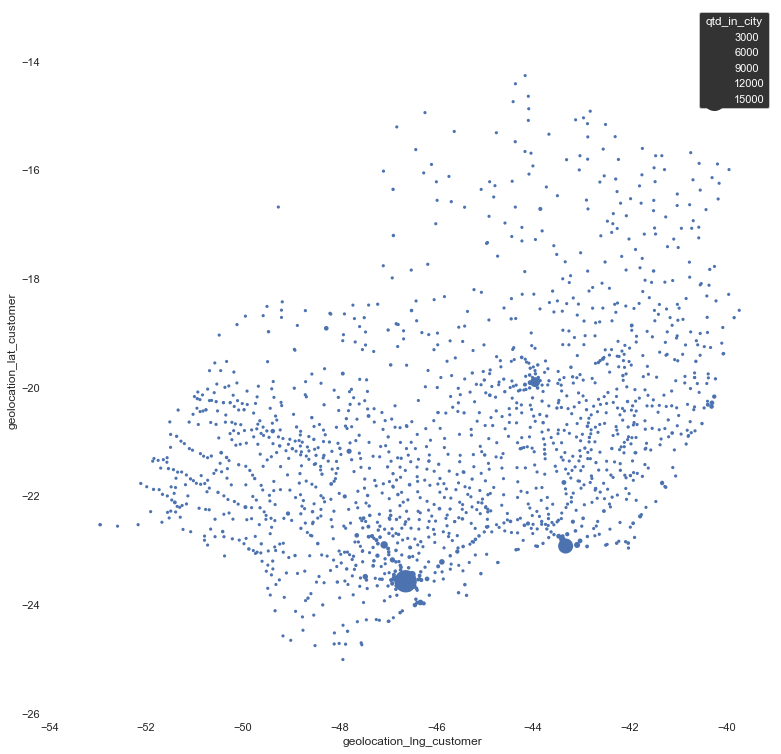

In [58]:
fig, ax = plt.subplots(figsize = (13,13))
plt.style.use('dark_background')
sns.scatterplot(data=df_sudeste_agregado,
                x='geolocation_lng_customer',
                y='geolocation_lat_customer',
                size='qtd_in_city',
                sizes=(10, 500),
                linewidth=0)

ax.set_xlim(-54,-39)
ax.set_ylim(-26,-13)

In [59]:
df_sudeste[['geolocation_lat_customer','geolocation_lng_customer']]

,geolocation_lat_customer,geolocation_lng_customer
0,-23.574809,-46.587471
6,-23.675037,-46.524784
9,-22.800936,-43.424861
11,-23.478754,-47.467931
13,-22.886501,-43.268834
...,...,...
119134,-20.147537,-44.907125
119136,-23.495994,-46.742453
119137,-23.178732,-45.889711
119138,-24.001467,-46.446355


# CLUSTERING CUSTOMER

**TODO** : Remover outlier para não criar clusters inuteis sem relevancia

## Creating Useful Columns

In [60]:
df_full_table['distance'] = \
                            df_full_table.apply(lambda row : distance(lat1=row['geolocation_lat_seller'],
                                     lat2=row['geolocation_lat_customer'],
                                     lon1=row['geolocation_lng_seller'] ,
                                     lon2=row['geolocation_lng_customer']), axis=1)

In [61]:
df_full_table.head(2)

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,payment_sequential,payment_type,...,seller_zip_code_prefix,seller_city,seller_state,geolocation_zip_code_prefix_seller,geolocation_lat_seller,geolocation_lng_seller,geolocation_city_seller,geolocation_state_seller,LAT_LONG_seller,distance
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18,1.0,credit_card,...,9350.0,maua,SP,9350.0,-23.680114,-46.452454,maua,SP,-23.68011442853022-46.4524537436668,18.063837
1,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18,3.0,voucher,...,9350.0,maua,SP,9350.0,-23.680114,-46.452454,maua,SP,-23.68011442853022-46.4524537436668,18.063837


In [62]:
[col for col in df_full_table if 'value' in col]

['payment_value', 'freight_value']

In [63]:
df_full_table['days_to_deliver'] = (df_full_table['order_delivered_customer_date'] - df_full_table['order_purchase_timestamp']).dt.days
df_full_table['delta_to_deliver'] = df_full_table['order_delivered_customer_date'] - df_full_table['order_purchase_timestamp']
df_full_table['hours_to_deliver'] = df_full_table['delta_to_deliver'].apply(days_hours_minutes)

df_full_table['hours_delay'] = (df_full_table['order_estimated_delivery_date'] - df_full_table['order_delivered_customer_date']).dt.days
df_full_table['delta_delay'] = df_full_table['order_estimated_delivery_date'] - df_full_table['order_delivered_customer_date']

## Removing Nulls from important columns

In [297]:
COLUMSN_TO_REMOVE_NULLS = ['distance',
'price',
'geolocation_lat_customer',
'geolocation_lng_customer',
'hours_to_deliver',
'hours_delay',
'freight_value']

In [66]:
for col in df_full_table[COLUMSN_TO_REMOVE_NULLS]:
    print((col, df_full_table[col].isna().sum()))

('distance', 1414)
('price', 833)
('geolocation_lat_customer', 322)
('geolocation_lng_customer', 322)
('hours_to_deliver', 3421)
('hours_delay', 3421)
('freight_value', 833)


In [67]:
df_full_table_sem_nulls = df_full_table.dropna(subset=COLUMSN_TO_REMOVE_NULLS)

## Removing OUTLIERS

In [288]:
COLS_TO_EVALUATE_OUTLIERS = ['distance',
'price',
'hours_to_deliver',
'hours_delay',
'freight_value']

['distance', 'price', 'hours_to_deliver', 'hours_delay', 'freight_value']

In [69]:
# Finding variables bouderies
dict_cortes = {}

for col in COLS_TO_EVALUATE_OUTLIERS:
    quantiles = np.quantile(df_full_table_sem_nulls[col], q=[0.25, 0.5, 0.75, 0.98])
    corte = quantiles[-1]
    tuple_col_corte = (col, round(corte,3))
    print(tuple_col_corte)
    dict_cortes[tuple_col_corte[0]] = tuple_col_corte[1]

('distance', 2355.109)
('price', 615.437)
('hours_to_deliver', 929.84)
('hours_delay', 31.0)
('freight_value', 64.928)


In [70]:
SIZE_BEFORE = df_full_table_sem_nulls.shape[0]

In [71]:
c1 = df_full_table_sem_nulls['distance'] <= dict_cortes['distance']
c2 = df_full_table_sem_nulls['price'] <= dict_cortes['price']
c3 = df_full_table_sem_nulls['hours_to_deliver'] <= dict_cortes['hours_to_deliver']
c4 = (df_full_table_sem_nulls['hours_delay'] >= 0) & (df_full_table_sem_nulls['hours_delay'] <= dict_cortes['hours_delay'])
c5 = df_full_table_sem_nulls['freight_value'] <= dict_cortes['freight_value']

df_full_table_no_nulls_no_outliers = df_full_table_sem_nulls[c1 & c2 & c3 & c4 & c5]

In [72]:
SIZE_AFTER = df_full_table_no_nulls_no_outliers.shape[0]

In [73]:
RED = round(100 * (SIZE_BEFORE - SIZE_AFTER) / SIZE_BEFORE, 2)
print(f"Base reduced in {RED}%")

Base reduced in 14.47%


## Aggregating Customer_unique_id

In [503]:
%%time 

def resolve_all_function(group):
    d = {}
    d['number_of_orders'] = group.shape[0]
    d['avg_distance'] = group['distance'].mean()
    d['avg_ticket'] = group['price'].mean()
    d['lat'] = group['geolocation_lat_customer'].mean()
    d['lng'] = group['geolocation_lng_customer'].mean()
    d['avg_hours_to_deliver'] = group['hours_to_deliver'].mean()
    d['avg_hours_delay'] = group['hours_delay'].mean()
    d['avg_freight_value'] = group['freight_value'].mean()

    return pd.Series(d, index=['number_of_orders',
                               'avg_distance',
                               'avg_ticket',
                               'lat', 'lng',
                               'avg_hours_to_deliver',
                               'avg_hours_delay',
                               'avg_freight_value'])


df_agg = df_full_table_no_nulls_no_outliers \
            .groupby('customer_unique_id') \
            .apply(resolve_all_function) \
            .reset_index()

Wall time: 40.1 s


## Scaling

In [504]:
COLUMNS_TO_SCALE = ['distance', 'price', 'geolocation_lat_customer', 'geolocation_lng_customer', 'hours_to_deliver', 'hours_delay', 'freight_value']

In [505]:
COLUMNS_TO_SCALE = ['avg_distance',
'avg_ticket',
'lat', 'lng',
'avg_hours_to_deliver',
'avg_hours_delay',
'avg_freight_value']

In [507]:
# Example of a normalization
from numpy import asarray
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
scaled = scaler.fit_transform(np.array(df_agg[COLUMNS_TO_SCALE]))

In [508]:
COLUMN_NAMES_SCALED = [str(col)+'_scaled' for col in COLUMNS_TO_SCALE]

In [509]:
df_scaled = pd.DataFrame(scaled, columns=COLUMN_NAMES_SCALED)

In [567]:
df_concated = pd.concat([df_agg[['customer_unique_id'] + COLUMNS_TO_SCALE].reset_index(drop=True), df_scaled], axis=1)

## Cluster Model Kmeans

In [569]:
import seaborn as sns
import pandas as pd
from sklearn.cluster import KMeans

In [570]:
N_CLUSTER = 8
INIT = 'k-means++'
N_INIT = 10
MAX_ITER = 300


kmeans = KMeans(n_clusters = N_CLUSTER, #numero de clusters
                init = INIT,
                n_init = N_INIT, #algoritmo que define a posição dos clusters de maneira mais assertiva
                max_iter = MAX_ITER)

COLUMNS_TO_CLUSTER = [ # tirei 'number_of_orders'
                   'avg_distance_scaled',
                   'avg_ticket_scaled',
                   'lat_scaled', 'lng_scaled',
                   'avg_hours_to_deliver_scaled',
                   'avg_hours_delay_scaled',
                   'avg_freight_value_scaled']


kmeans.fit(df_concated[COLUMNS_TO_CLUSTER])

df_concated['Cluster'] = kmeans.predict(df_concated[COLUMNS_TO_CLUSTER])

In [571]:
df_concated.drop(columns='customer_unique_id').corr()

,avg_distance,avg_ticket,lat,lng,avg_hours_to_deliver,avg_hours_delay,avg_freight_value,avg_distance_scaled,avg_ticket_scaled,lat_scaled,lng_scaled,avg_hours_to_deliver_scaled,avg_hours_delay_scaled,avg_freight_value_scaled,Cluster
avg_distance,1.000000,0.073189,0.634738,0.276318,0.502789,0.195340,0.515219,1.000000,0.073189,0.634738,0.276318,0.502789,0.195340,0.515219,-0.130124
avg_ticket,0.073189,1.000000,0.040451,0.016043,0.075753,0.034656,0.339195,0.073189,1.000000,0.040451,0.016043,0.075753,0.034656,0.339195,0.010528
lat,0.634738,0.040451,1.000000,0.539994,0.270490,0.065490,0.323479,0.634738,0.040451,1.000000,0.539994,0.270490,0.065490,0.323479,-0.150916
lng,0.276318,0.016043,0.539994,1.000000,0.104090,0.019994,0.135326,0.276318,0.016043,0.539994,1.000000,0.104090,0.019994,0.135326,-0.152416
avg_hours_to_deliver,0.502789,0.075753,0.270490,0.104090,1.000000,-0.203939,0.341178,0.502789,0.075753,0.270490,0.104090,1.000000,-0.203939,0.341178,-0.355731
avg_hours_delay,0.195340,0.034656,0.065490,0.019994,-0.203939,1.000000,0.145398,0.195340,0.034656,0.065490,0.019994,-0.203939,1.000000,0.145398,0.251411
avg_freight_value,0.515219,0.339195,0.323479,0.135326,0.341178,0.145398,1.000000,0.515219,0.339195,0.323479,0.135326,0.341178,0.145398,1.000000,-0.124457
avg_distance_scaled,1.000000,0.073189,0.634738,0.276318,0.502789,0.195340,0.515219,1.000000,0.073189,0.634738,0.276318,0.502789,0.195340,0.515219,-0.130124
avg_ticket_scaled,0.073189,1.000000,0.040451,0.016043,0.075753,0.034656,0.339195,0.073189,1.000000,0.040451,0.016043,0.075753,0.034656,0.339195,0.010528
lat_scaled,0.634738,0.040451,1.000000,0.539994,0.270490,0.065490,0.323479,0.634738,0.040451,1.000000,0.539994,0.270490,0.065490,0.323479,-0.150916


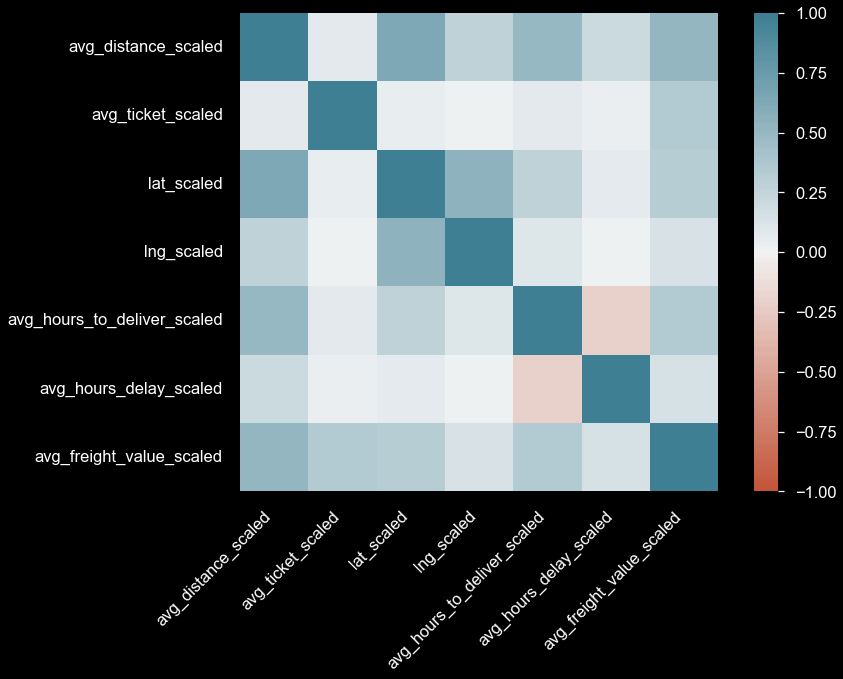

In [575]:
corr = df_concated[COLUMNS_TO_CLUSTER].corr()

ax = sns.heatmap(
    corr, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
);

## Merging with full dataframe to retrieve other columns

In [577]:
df = df_full_table_sem_nulls.merge(df_concated, on='customer_unique_id', how='inner')

In [578]:
df.avg_ticket_scaled.isna().sum()

0

In [579]:
# DESIRE: Only one register per customer
df_sem_duplicados = df.drop_duplicates('customer_unique_id') 

In [580]:
# Tira fora o que não tem cluster definido (problema vem na hora do merge com full_table)
df_sem_duplicados = df_sem_duplicados.dropna(subset=['Cluster'])

In [581]:
df_sem_duplicados.Cluster = df_sem_duplicados.Cluster.astype(int)

In [582]:
cluster_color_map = {
    0: '#eb1717',
    1: '#f58f0a',
    2: '#7de84f',
    3: '#02f7d3',
    4: '#0516ff',
    5: '#d505ff',
    6: '#ff05a8',
    7: '#f6ff00'
}

In [583]:
cluster_color_map = {
    0: "#999999",
    1: "#E69F00",
    2: "#56B4E9",
    3: "#009E73",
    4: "#F0E442",
    5: "#0072B2",
    6: "#D55E00",
    7: "#CC79A7"
}

In [584]:
cluster_color_map = {
    0: "#8dd3c7",
    1: "#ffffb3",
    2: "#bebada",
    3: "#fb8072",
    4: "#80b1d3",
    5: "#fdb462",
    6: "#b3de69",
    7: "#fccde5"
}

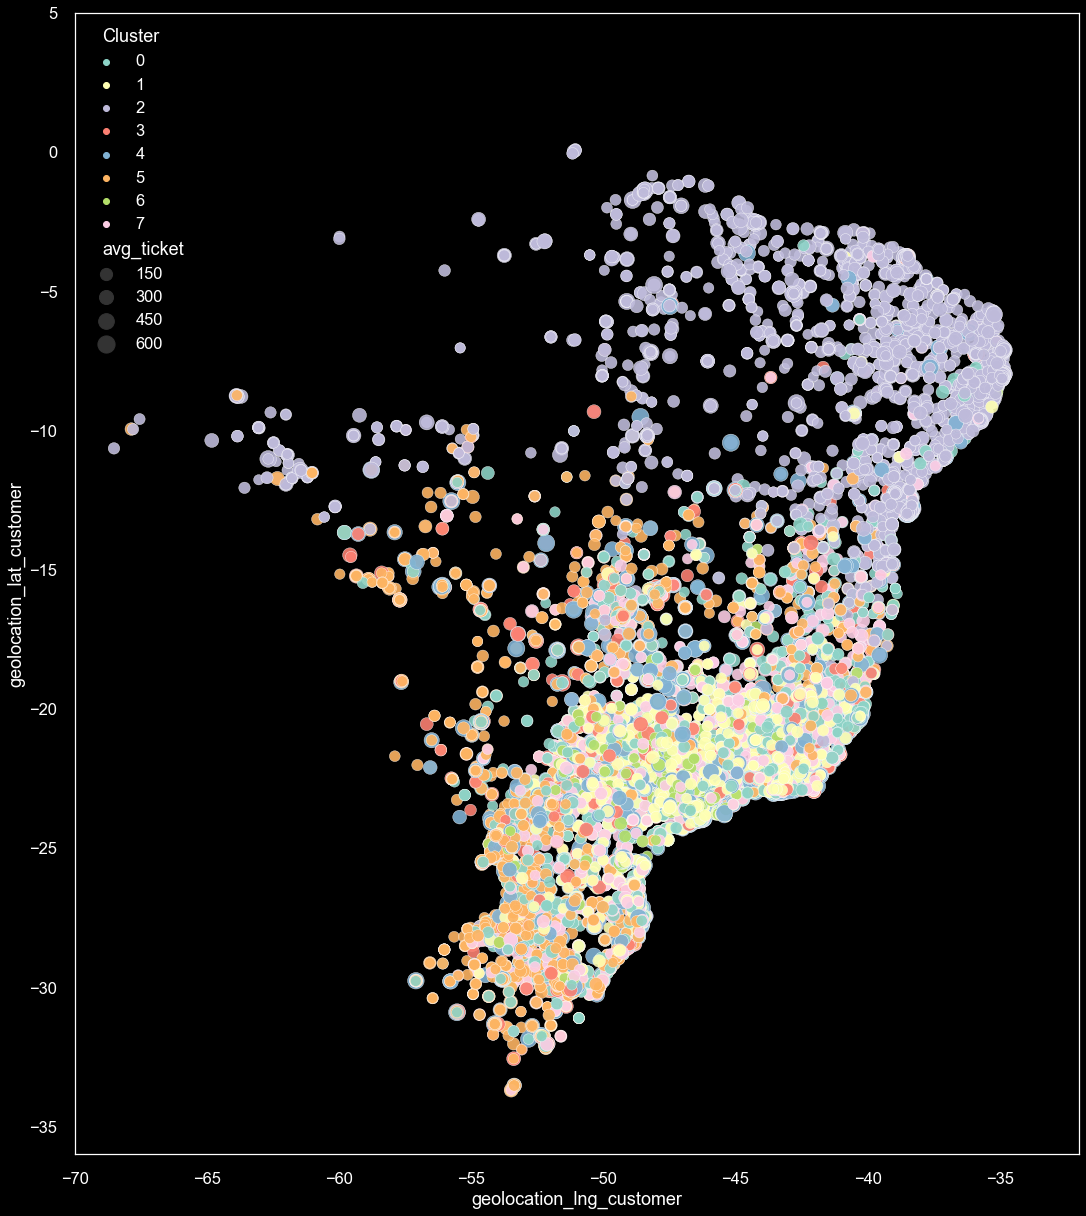

In [585]:
# Para tirar a densidade do gráfico, exibe uma amostra de 10% do total
df_sem_duplicados_sampled = df_sem_duplicados.sample(int(df_sem_duplicados.shape[0] * 1))

fig, ax = plt.subplots(figsize = (18,21))
sns.scatterplot(data=df_sem_duplicados_sampled,
                x='geolocation_lng_customer',
                y='geolocation_lat_customer',
                hue='Cluster',
                alpha=0.9,
                size='avg_ticket',
                sizes=(100, 300),
                linewidth=0.4,
                palette=cluster_color_map)

plt.style.use('dark_background')
ax.set_xlim(-70,-32);
ax.set_ylim(-36,5);

In [586]:
for col in COLUMNS_TO_CLUSTER:
    print(f'\n\n\n\n{col}___________')
    display(df_sem_duplicados.groupby('Cluster')[col].describe().reset_index().sort_values('mean', ascending=False))





avg_distance_scaled___________


,Cluster,count,mean,std,min,25%,50%,75%,max
2,2,6498.0,0.774750,0.152029,0.266174,0.632543,0.802402,0.903927,1.000000
5,5,8870.0,0.367604,0.103461,0.117849,0.302556,0.358816,0.412150,0.988091
7,7,9418.0,0.234463,0.123923,0.000000,0.147868,0.214776,0.320700,0.900109
3,3,2946.0,0.232196,0.145261,0.000000,0.136363,0.201221,0.324103,0.900285
0,0,11763.0,0.230454,0.110399,0.001784,0.149910,0.213874,0.305334,0.797501
4,4,3914.0,0.186843,0.139351,0.000000,0.075749,0.161582,0.264910,0.894840
1,1,20294.0,0.133022,0.077130,0.000000,0.068275,0.140194,0.189960,0.418914
6,6,15692.0,0.048866,0.056332,0.000000,0.008949,0.026322,0.061865,0.396399






avg_ticket_scaled___________


,Cluster,count,mean,std,min,25%,50%,75%,max
4,4,3914.0,0.596842,0.170078,0.324269,0.469385,0.552210,0.698608,1.000000
3,3,2946.0,0.278796,0.142444,0.023040,0.177709,0.242709,0.355206,0.973948
2,2,6498.0,0.178120,0.146591,0.006594,0.078401,0.143532,0.241228,0.975006
7,7,9418.0,0.145917,0.102222,0.004315,0.065513,0.120736,0.201986,0.675486
0,0,11763.0,0.142997,0.097211,0.000000,0.070309,0.120573,0.194008,0.635675
5,5,8870.0,0.134101,0.088665,0.003598,0.063730,0.112432,0.185867,0.552064
1,1,20294.0,0.125547,0.081711,0.000000,0.062102,0.104453,0.174469,0.420337
6,6,15692.0,0.112489,0.084461,0.002198,0.047448,0.088008,0.153953,0.535944






lat_scaled___________


,Cluster,count,mean,std,min,25%,50%,75%,max
2,2,6498.0,0.735084,0.130280,0.176994,0.646812,0.758909,0.826491,1.000000
0,0,11763.0,0.389822,0.096116,0.083932,0.355226,0.374378,0.444748,0.958236
7,7,9418.0,0.387988,0.093830,0.079413,0.355272,0.373451,0.438080,0.959489
3,3,2946.0,0.383767,0.097286,0.000000,0.354008,0.373140,0.426945,0.896052
4,4,3914.0,0.382445,0.088944,0.083932,0.354182,0.370531,0.419097,0.898660
1,1,20294.0,0.380365,0.057377,0.122868,0.355108,0.370492,0.404555,0.929375
6,6,15692.0,0.363900,0.037202,0.110140,0.353981,0.356491,0.370182,0.929189
5,5,8870.0,0.362148,0.144996,0.000000,0.223912,0.359734,0.479776,0.759434






lng_scaled___________


,Cluster,count,mean,std,min,25%,50%,75%,max
2,2,6498.0,0.831819,0.162323,0.000000,0.762494,0.888595,0.941772,1.000000
7,7,9418.0,0.662668,0.099222,0.137062,0.599870,0.651516,0.745952,0.997256
0,0,11763.0,0.661054,0.104263,0.258691,0.589592,0.652010,0.746043,0.998530
1,1,20294.0,0.658658,0.071223,0.338704,0.625053,0.649050,0.724174,0.997371
4,4,3914.0,0.648222,0.092050,0.274199,0.594108,0.647776,0.725197,0.996572
6,6,15692.0,0.644741,0.041797,0.369730,0.639665,0.647950,0.652359,0.998903
3,3,2946.0,0.643652,0.104603,0.125315,0.577443,0.647468,0.734615,0.967644
5,5,8870.0,0.563306,0.120012,0.019476,0.483407,0.540972,0.631673,0.893492






avg_hours_to_deliver_scaled___________


,Cluster,count,mean,std,min,25%,50%,75%,max
0,0,11763.0,0.452241,0.125976,0.143013,0.360262,0.433406,0.521834,0.989083
2,2,6498.0,0.432127,0.159058,0.048035,0.316594,0.410480,0.534934,1.000000
5,5,8870.0,0.319315,0.103466,0.068777,0.245633,0.310044,0.380459,0.901747
3,3,2946.0,0.299475,0.149630,0.015284,0.192140,0.274017,0.381823,0.956332
4,4,3914.0,0.249777,0.129556,0.000000,0.160480,0.228166,0.324236,0.929039
7,7,9418.0,0.217942,0.101305,0.008734,0.149563,0.200873,0.271834,0.923581
1,1,20294.0,0.189767,0.081576,0.006550,0.133188,0.184498,0.246452,0.546943
6,6,15692.0,0.145115,0.079831,0.008734,0.081878,0.136463,0.197598,0.401747






avg_hours_delay_scaled___________


,Cluster,count,mean,std,min,25%,50%,75%,max
7,7,9418.0,0.727351,0.112382,0.516129,0.645161,0.709677,0.806452,1.000000
5,5,8870.0,0.447465,0.107822,0.064516,0.387097,0.451613,0.516129,0.838710
1,1,20294.0,0.443764,0.080538,0.225806,0.387097,0.419355,0.483871,0.677419
2,2,6498.0,0.439373,0.218110,0.000000,0.290323,0.419355,0.612903,1.000000
3,3,2946.0,0.405384,0.180399,0.000000,0.290323,0.419355,0.516129,1.000000
4,4,3914.0,0.393358,0.168766,0.000000,0.258065,0.387097,0.483871,1.000000
6,6,15692.0,0.217183,0.092303,0.000000,0.161290,0.225806,0.290323,0.419355
0,0,11763.0,0.184634,0.102628,0.000000,0.096774,0.193548,0.258065,0.677419






avg_freight_value_scaled___________


,Cluster,count,mean,std,min,25%,50%,75%,max
3,3,2946.0,0.692130,0.140074,0.405214,0.577549,0.673762,0.788524,0.999692
2,2,6498.0,0.449860,0.171410,0.000000,0.326238,0.397501,0.555453,1.000000
4,4,3914.0,0.318394,0.116201,0.009718,0.249730,0.291223,0.361060,0.942619
5,5,8870.0,0.290067,0.068741,0.000000,0.245758,0.274718,0.315440,0.666975
7,7,9418.0,0.275935,0.082468,0.000000,0.232917,0.263613,0.302175,0.822150
0,0,11763.0,0.270171,0.072198,0.000000,0.232917,0.254975,0.289835,0.799321
1,1,20294.0,0.229223,0.063351,0.000000,0.195743,0.223970,0.259602,0.565942
6,6,15692.0,0.171835,0.061667,0.000000,0.122628,0.147154,0.202221,0.597409


## Graphics to analyze specific Cluster
In this case, Cluster 5

In [587]:
COLUMNS_TO_GRAPHICS = COLUMNS_TO_CLUSTER

In [600]:
COLUMNS_TO_GRAPHICS.remove('lat_scaled')
COLUMNS_TO_GRAPHICS.remove('lng_scaled')

In [601]:
COLUMNS_TO_GRAPHICS

['avg_distance_scaled',
 'avg_ticket_scaled',
 'avg_hours_to_deliver_scaled',
 'avg_hours_delay_scaled',
 'avg_freight_value_scaled']

In [602]:
dict_col_name = {'avg_distance_scaled':'Avg Distance',
'avg_ticket_scaled':'Avg Ticket',
'avg_hours_to_deliver_scaled':'Avg Hours to Deliver',
'avg_hours_delay_scaled':'Avg Hours of Delay',
'avg_freight_value_scaled':'Avg Freight Value'}

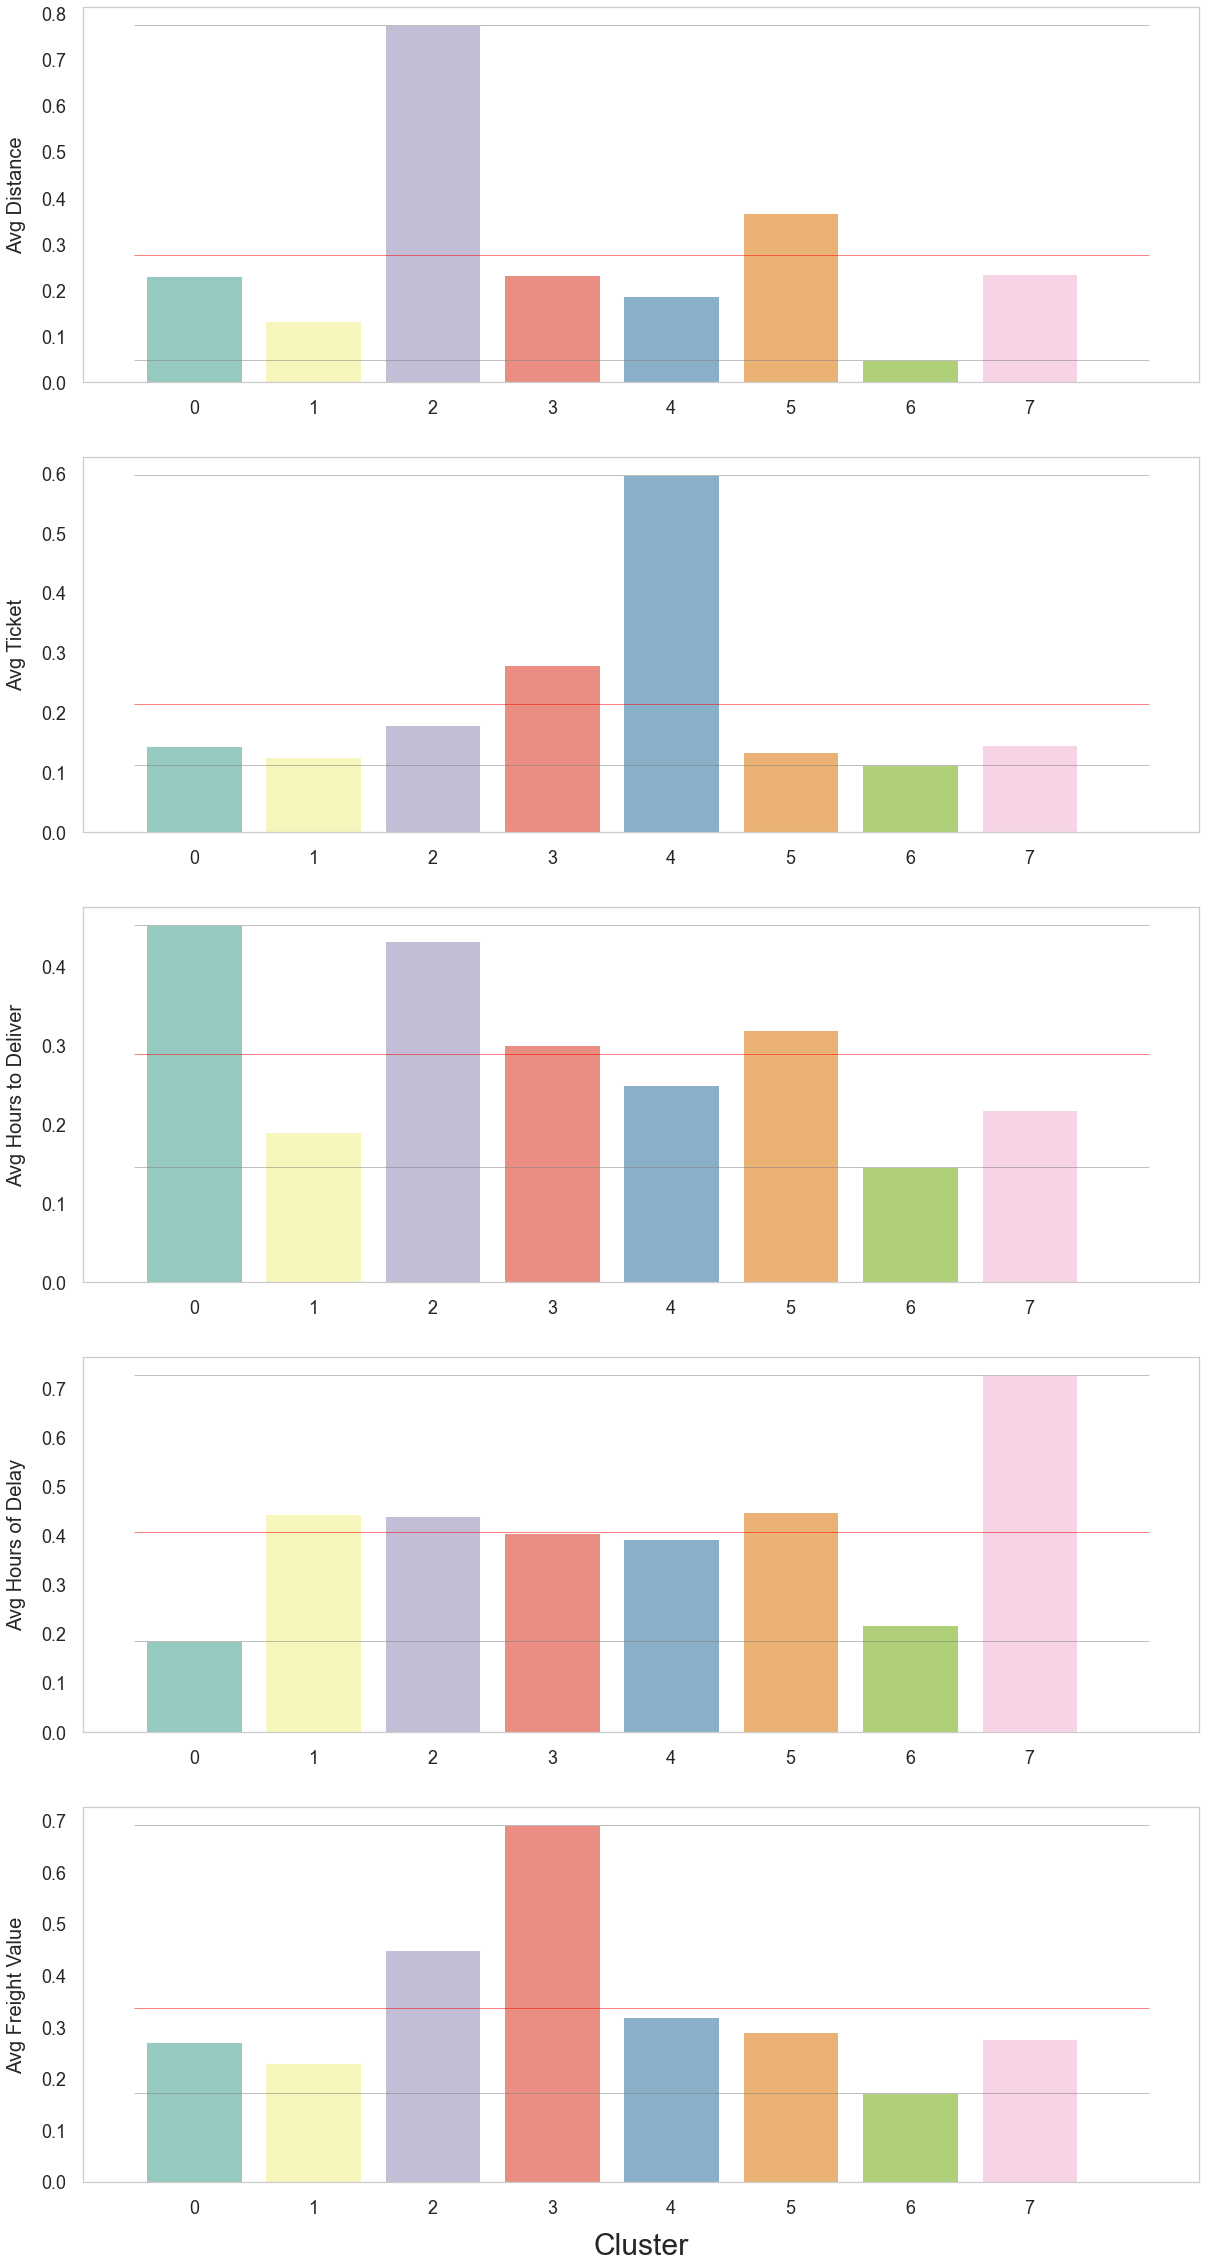

In [606]:
fig, axes = plt.subplots(nrows=len(COLUMNS_TO_GRAPHICS), figsize=(20,40))
sns.set_style('whitegrid')

plt.grid(False)

for index, col in enumerate(COLUMNS_TO_GRAPHICS):
    d = df_sem_duplicados.groupby('Cluster')[COLUMNS_TO_GRAPHICS].mean().reset_index()
    sns.barplot(data=d, x='Cluster', y=col, ax=axes[index], palette=cluster_color_map)
    
    # MIN, MAX, MEAN
    axes[index].hlines(y=d[col].max(), xmin=-0.5, xmax=8, colors='grey', linestyles='solid', linewidth=0.5)
    axes[index].hlines(y=d[col].min(), xmin=-0.5, xmax=8, colors='grey', linestyles='solid', linewidth=0.5)
    axes[index].hlines(y=d[col].mean(), xmin=-0.5, xmax=8, colors='red', linestyles='solid', linewidth=0.5)

    # STYLING BARS & TICKS, LABELS
    axes[index].set_ylabel(ylabel=dict_col_name[col], labelpad=15)
    axes[index].yaxis.label.set_fontsize(20)
    axes[index].set_xlabel(xlabel="", labelpad=15)
    axes[index].tick_params(direction='out', labelsize=18)
    axes[index].grid(False)

sns.set_style("whitegrid", {'axes.grid' : False})

axes[-1].set_xlabel(xlabel="Cluster", labelpad=15)
axes[-1].xaxis.label.set_fontsize(30)

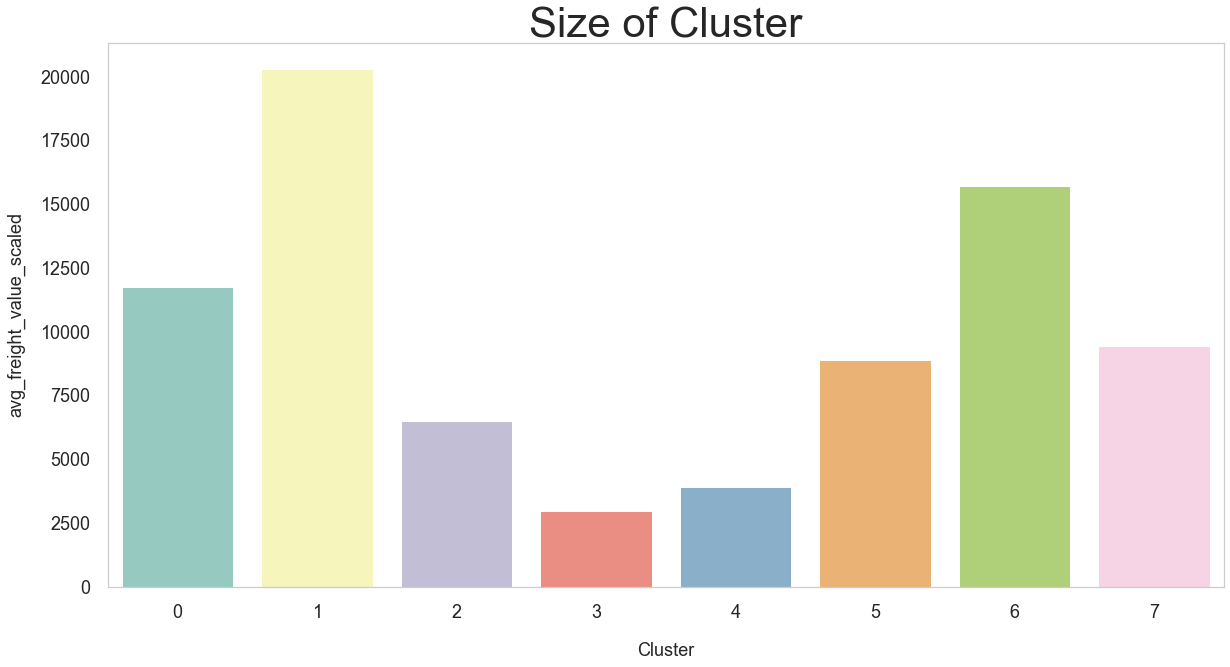

In [604]:
df_cluster_size = df_sem_duplicados.groupby('Cluster').size().rename('Cluster Size').reset_index()
fig, ax_cluster_size = plt.subplots(nrows=1, figsize=(20,10))

sns.barplot(data=df_cluster_size, x='Cluster', y='Cluster Size', palette=cluster_color_map, ax=ax_cluster_size)

# STYLING BARS & TICKS, LABELS
ax_cluster_size.set_title("Size of Cluster", fontsize=42)
ax_cluster_size.set_ylabel(ylabel=col, labelpad=15)
ax_cluster_size.yaxis.label.set_fontsize(18)
ax_cluster_size.xaxis.label.set_fontsize(18)
ax_cluster_size.set_xlabel(xlabel="Cluster", labelpad=20)
ax_cluster_size.tick_params(direction='out', labelsize=18)

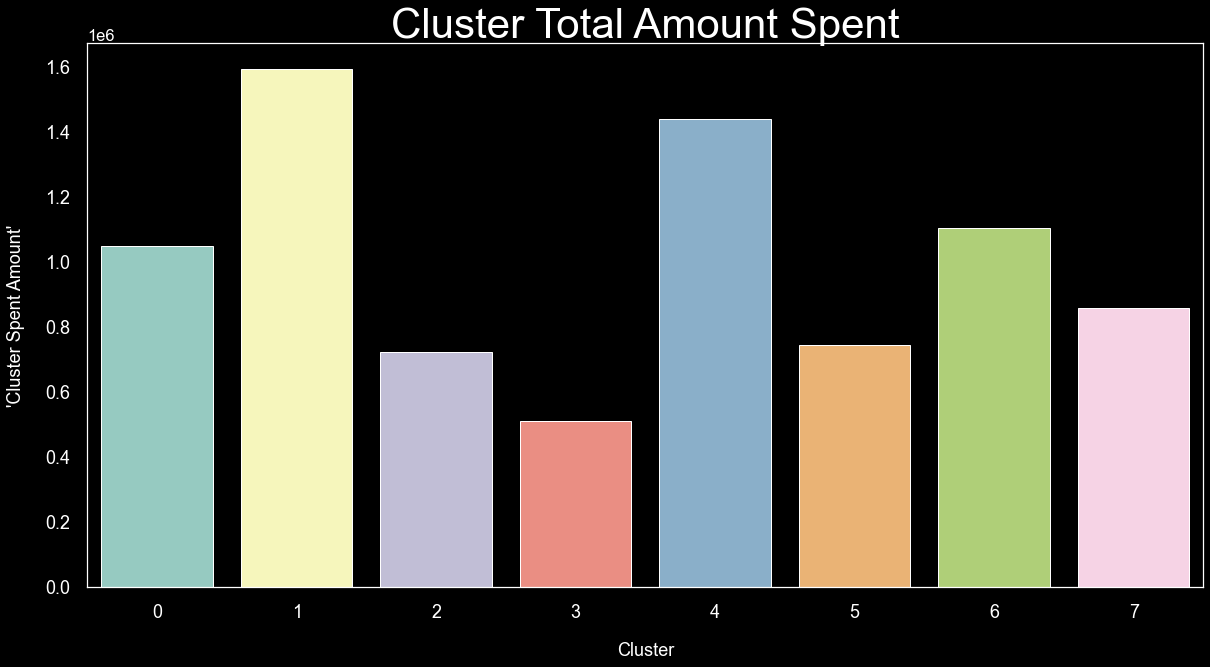

In [626]:
df_grouped_by_total_amount = df_sem_duplicados.drop_duplicates('order_id').groupby('Cluster')['price'].sum().rename('Cluster Spent Amount').reset_index()

fig, ax_cluster_size = plt.subplots(nrows=1, figsize=(20,10))

sns.barplot(data=df_grouped_by_total_amount, x='Cluster', y='Cluster Spent Amount', palette=cluster_color_map, ax=ax_cluster_size)

# STYLING BARS & TICKS, LABELS
ax_cluster_size.set_title("Cluster Total Amount Spent", fontsize=42)
ax_cluster_size.set_ylabel(ylabel=col, labelpad=15)
ax_cluster_size.yaxis.label.set_fontsize(18)
ax_cluster_size.xaxis.label.set_fontsize(18)
ax_cluster_size.set_xlabel(xlabel="Cluster", labelpad=20)
ax_cluster_size.set_ylabel(ylabel="'Cluster Spent Amount'", labelpad=20)

ax_cluster_size.tick_params(direction='out', labelsize=18)

Text(0.5, 1.0, 'Ticket Médio vs Tempo para Receber Entrega')

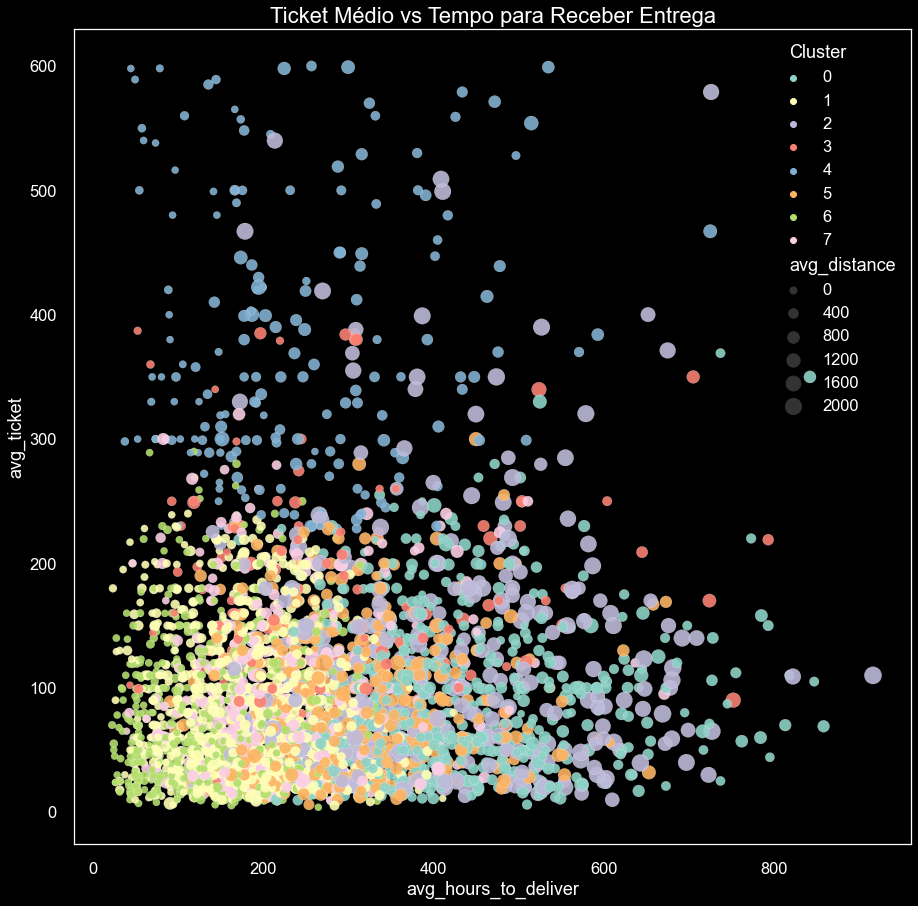

In [608]:
# Para tirar a densidade do gráfico, exibe uma amostra de 10% do total
df_sem_duplicados_sampled = df_sem_duplicados.sample(int(df_sem_duplicados.shape[0] * 0.05))

fig, ax = plt.subplots(figsize = (15,15))
plt.style.use('dark_background')
sns.scatterplot(data=df_sem_duplicados_sampled,
                x='avg_hours_to_deliver',
                y='avg_ticket',
                hue='Cluster',
                alpha=0.9,
                size='avg_distance',
                sizes=(50, 300),
                linewidth=0.2,
                palette=cluster_color_map)

ax.set_title("Ticket Médio vs Tempo para Receber Entrega", fontsize=22)
# ax.set_xlim(0,1500);
# ax.set_ylim(0,1500);

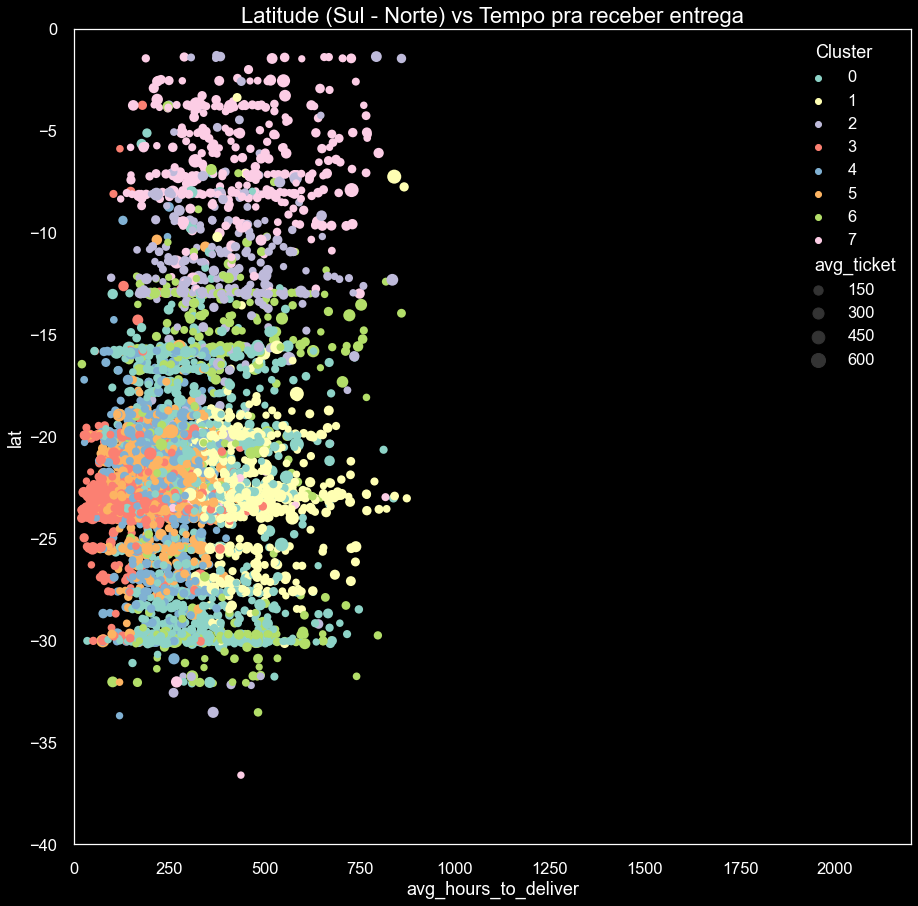

In [250]:
# Para tirar a densidade do gráfico, exibe uma amostra de 10% do total
df_sem_duplicados_sampled = df_sem_duplicados.sample(int(df_sem_duplicados.shape[0] * 0.1))

fig, ax = plt.subplots(figsize = (15,15))
plt.style.use('dark_background')
sns.scatterplot(data=df_sem_duplicados_sampled,
                x='avg_hours_to_deliver',
                y='lat',
                hue='Cluster',
                size='avg_ticket',
                sizes=(50, 200),
                linewidth=0,
                palette=cluster_color_map)


ax.set_title("Latitude (Sul - Norte) vs Tempo pra receber entrega", fontsize=22)
ax.set_xlim(0,2200);
ax.set_ylim(-40,0);

Text(0.5, 1.0, 'Latitude (Sul - Norte) vs Tempo pra receber entrega')

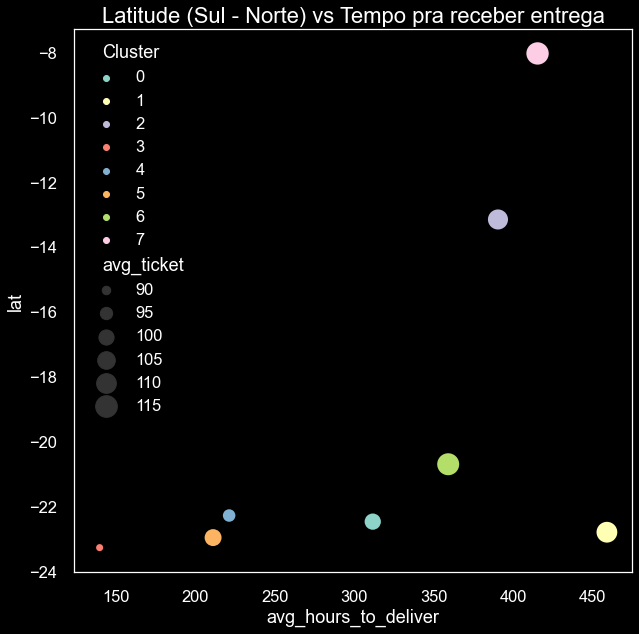

In [246]:
# Para tirar a densidade do gráfico, exibe uma amostra de 10% do total
# df_sem_duplicados_sampled = df_sem_duplicados.sample(int(df_sem_duplicados.shape[0] * 0.001))
df_grouped = df_sem_duplicados.groupby('Cluster').agg({'avg_ticket': 'mean', 'avg_hours_to_deliver': 'mean', 'lat': 'mean'}).reset_index()

fig, ax = plt.subplots(figsize = (10,10))
plt.style.use('dark_background')
sns.scatterplot(data=df_grouped,
                x='avg_hours_to_deliver',
                y='lat',
                hue='Cluster',
                size='avg_ticket',
                sizes=(50, 500),
                linewidth=0,
                palette=cluster_color_map)

ax.set_title("Latitude (Sul - Norte) vs Tempo pra receber entrega", fontsize=22)
# ax.set_xlim(0,2200);
# ax.set_ylim(-40,0);

In [93]:
# ! pip install yellowbrick --user

In [94]:
# # Elbow Method for K means
# # Import ElbowVisualizer
# from yellowbrick.cluster import KElbowVisualizer

# # k is range of number of clusters.
# visualizer = KElbowVisualizer(kmeans, k=(2,30), timings= True)
# visualizer.fit(df_rfm_sem_nulls[COLUMNS_TO_CLUSTER])        # Fit data to visualizer
# visualizer.show()        # Finalize and render figure